# Importing the Dependencies 

In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from dotenv import load_dotenv

load_dotenv()

True

# Loading the Data 

In [2]:
%pip install fsspec

Note: you may need to restart the kernel to use updated packages.


In [3]:
folder_path=os.getenv("FOLDER_PATH")
file_path = os.path.join(folder_path, "features_scores.csv")
results_df=pd.read_csv(file_path)
print(results_df.head())
print("*"*60)
print(f"Shape of the df is {results_df.shape}")
print("*"*60)
print(results_df.info())

   total_tx            gas_spent     avg_value     max_value  activity_days  \
0       100  2377481427161696080  5.225464e+17  5.000000e+19            794   
1         5    15559648000000000  4.860370e+15  1.860000e+16              0   
2         4    15780978000000000  4.650000e+15  1.860000e+16              0   
3        80  1725902402924921473  2.523044e+18  6.756315e+19           2067   
4         5    14405516000000000  5.200938e+15  1.860000e+16             63   

                                       wallet  risk_score  
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3      996.78  
1  0x06b51c6882b27cb05e712185531c1f74996dd988      750.00  
2  0x0795732aacc448030ef374374eaae57d2965c16c      740.00  
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9      996.20  
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae      946.87  
************************************************************
Shape of the df is (103, 7)
************************************************************
<class 'pandas.

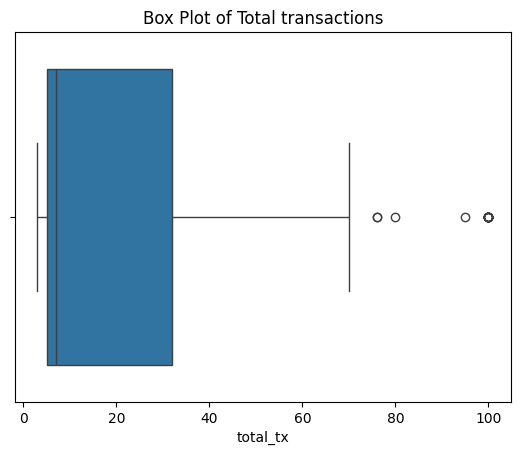

This plot suggests that there are some outlier wallets


In [4]:
sns.boxplot(data=results_df,x='total_tx')
plt.title("Box Plot of Total transactions")
plt.show()
print("This plot suggests that there are some outlier wallets")

In [5]:
print(results_df.describe())

         total_tx     gas_spent     avg_value     max_value  activity_days  \
count  103.000000  1.030000e+02  1.030000e+02  1.030000e+02     103.000000   
mean    27.407767  2.412921e+17  3.276201e+17  1.010153e+19     610.165049   
std     36.106986  4.958866e+17  1.649833e+18  5.413831e+19     801.509765   
min      3.000000  2.744473e+15  0.000000e+00  0.000000e+00       0.000000   
25%      5.000000  1.006421e+16  4.650000e+15  1.860000e+16       0.000000   
50%      7.000000  1.792964e+16  6.277160e+15  1.860000e+16     147.000000   
75%     32.000000  1.752437e+17  5.221340e+16  4.938344e+17    1307.000000   
max    100.000000  2.423633e+18  1.567911e+19  5.000000e+20    2862.000000   

       risk_score  
count  103.000000  
mean   895.511262  
std    115.463728  
min    462.500000  
25%    750.000000  
50%    949.620000  
75%    988.455000  
max    996.950000  


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
normalized_features = pd.DataFrame(
    scaler.fit_transform(results_df[['total_tx', 'gas_spent', 'avg_value', 'max_value', 'activity_days']]),
    columns=['total_tx', 'gas_spent', 'avg_value', 'max_value', 'activity_days']
)

# Weighted formula to simulate risk (you can tweak weights based on intuition)
results_df['risk_score_features'] = (
    0.3 * (1 - normalized_features['avg_value']) +  # low avg value → higher risk
    0.25 * normalized_features['gas_spent'] +       # high gas spent → high activity (maybe lower risk)
    0.2 * (1 - normalized_features['activity_days']) + # few active days → more risky
    0.15 * (1 - normalized_features['total_tx']) +  # fewer transactions → more risky
    0.1 * normalized_features['max_value']          # high max txn value → could imply some risky bet
)


print(results_df['risk_score'],results_df['risk_score_features'])


0      996.78
1      750.00
2      740.00
3      996.20
4      946.87
        ...  
98     679.77
99     915.00
100    740.00
101    978.45
102    740.00
Name: risk_score, Length: 103, dtype: float64 0      0.689750
1      0.648141
2      0.649715
3      0.529668
4      0.643613
         ...   
98     0.639837
99     0.648906
100    0.648730
101    0.540887
102    0.649625
Name: risk_score_features, Length: 103, dtype: float64


In [7]:
results_df['risk_score_features'] = 1000 * (results_df['risk_score_features'] / results_df['risk_score_features'].max())
print(results_df['risk_score_features'].head())


0    966.425098
1    908.126140
2    910.330490
3    742.129754
4    901.781549
Name: risk_score_features, dtype: float64


In [8]:
def simulate_risk_label(row):
    if row['risk_score_features'] >= 800:
        return "high"
    elif (row['risk_score_features'] >= 300) and (row['risk_score_features'] <= 800):
        return "medium"
    else:
        return "low"

results_df["risk_score_label"] = results_df.apply(simulate_risk_label, axis=1)


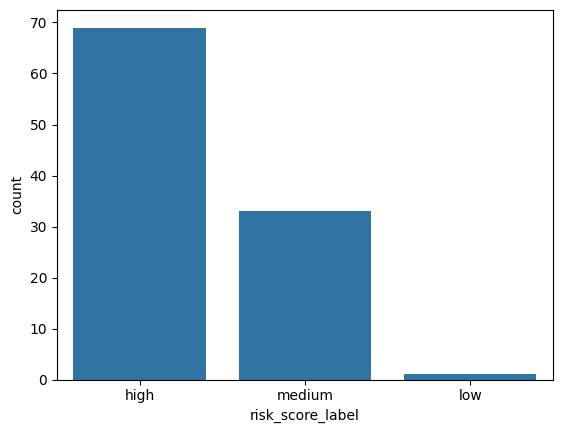

In [9]:
sns.barplot(results_df['risk_score_label'].value_counts())
plt.show()

In [10]:
print(results_df['risk_score_label'].value_counts())
results_df['risk_score_label'].map({"low":0,"medium":1,"high":2}) # For our ML Model to train we need numeric data type

risk_score_label
high      69
medium    33
low        1
Name: count, dtype: int64


0      2
1      2
2      2
3      1
4      2
      ..
98     2
99     2
100    2
101    1
102    2
Name: risk_score_label, Length: 103, dtype: int64

In [11]:
results_df.columns

Index(['total_tx', 'gas_spent', 'avg_value', 'max_value', 'activity_days',
       'wallet', 'risk_score', 'risk_score_features', 'risk_score_label'],
      dtype='object')

# Training Random Forest Regressor 

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


X = results_df.drop(columns=["wallet", "risk_score_label"])
y = results_df['risk_score_label'].map({"low":0,"medium":1,"high":2})

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


print("Training R²:", model.score(X_train, y_train))
print("Test R²:", model.score(X_test, y_test))


Training R²: 0.9888415313225059
Test R²: 0.99929125


In [13]:
results_df["predicted_risk_score"] = model.predict(X_scaled)
print(results_df['predicted_risk_score'].head())

results_df["predicted_risk_score"] = (results_df["predicted_risk_score"]*1000).clip(0, 1000).round(2)
print(results_df['predicted_risk_score'].value_counts())

file_path = os.path.join(folder_path, "final_ml_scores.csv")
results_df[["wallet", "predicted_risk_score"]].to_csv(file_path, index=False)


0    2.00
1    2.00
2    2.00
3    0.99
4    2.00
Name: predicted_risk_score, dtype: float64
predicted_risk_score
1000.0    95
990.0      4
960.0      2
430.0      1
980.0      1
Name: count, dtype: int64
